# Train

In [1]:
import wandb

wandb.init(project="PPO", entity="lwyjo")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lwyjo (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [2]:
import numpy as np
from collections import deque
import pickle
import torch
from ppo import PPOAgent
from utils import collect_trajectories, random_sample
from parallelEnv import parallelEnv

gamma = .99
gae_lambda = 0.95
use_gae = True

nenvs = 8
rollout_length = 200
minibatches = 10*8
# Calculate the batch_size
nbatch = nenvs * rollout_length
optimization_epochs = 4
seed=1

config = wandb.config
config.gamma = gamma
config.nenvs = nenvs
config.seed = seed

In [3]:


def train(episode,env_name):
    # gamma = .99
    # gae_lambda = 0.95
    # use_gae = True
    beta = .01
    cliprange = 0.1
    best_score = -np.inf
    goal_score = 195.0
    #
    # nenvs = 8
    # rollout_length = 200
    # minibatches = 10*8
    # # Calculate the batch_size
    # nbatch = nenvs * rollout_length
    # optimization_epochs = 4



    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    envs = parallelEnv(env_name, nenvs, seed=seed)
    agent = PPOAgent(state_size=envs.observation_space.shape[0],
                     action_size=envs.action_space.n, 
                     seed=0,
                     hidden_layers=[64,64],
                     lr_policy=1e-4, 
                     use_reset=True,
                     device=device)
    print("------------------")
    print(agent.policy)
    print("------------------")

    # keep track of progress
    mean_rewards = []
    scores_window = deque(maxlen=100)
    loss_storage = []

    for i_episode in range(episode+1):
        log_probs_old, states, actions, rewards, values, dones, vals_last = collect_trajectories(envs, agent.policy, rollout_length)

        returns = np.zeros_like(rewards)
        advantages = np.zeros_like(rewards)
        
        if not use_gae: #查GAE
            for t in reversed(range(rollout_length)):
                if t == rollout_length - 1:
                    returns[t] = rewards[t] + gamma * (1-dones[t]) * vals_last
                else:
                    returns[t] = rewards[t] + gamma * (1-dones[t]) * returns[t+1]
                advantages[t] = returns[t] - values[t]  #calculation of advantege funvtion LECTURE 7
        else:
            for t in reversed(range(rollout_length)):
                if t == rollout_length - 1:
                    returns[t] = rewards[t] + gamma * (1-dones[t]) * vals_last
                    td_error = returns[t] - values[t] # td error 与GAE关系
                else:
                    returns[t] = rewards[t] + gamma * (1-dones[t]) * returns[t+1]
                    td_error = rewards[t] + gamma * (1-dones[t]) * values[t+1] - values[t]
                advantages[t] = advantages[t] * gae_lambda * gamma * (1-dones[t]) + td_error
        
        # convert to pytorch tensors and move to gpu if available
        returns = torch.from_numpy(returns).float().to(device).view(-1,)
        advantages = torch.from_numpy(advantages).float().to(device).view(-1,)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-10)

        wandb.log({"returns": returns})
        wandb.log({"advantages": advantages})
        
        for _ in range(optimization_epochs):
            sampler = random_sample(nbatch, minibatches)
            for inds in sampler:
                mb_log_probs_old = log_probs_old[inds]
                mb_states = states[inds]
                mb_actions = actions[inds]
                mb_returns = returns[inds]
                mb_advantages = advantages[inds]
                loss_p, loss_v, loss_ent = agent.update(mb_log_probs_old, mb_states, mb_actions, mb_returns, mb_advantages, cliprange=cliprange, beta=beta)
                # wandb.log({"loss_p": loss_p})
                # wandb.log({"loss_v": loss_v})
                # wandb.log({"loss_ent": loss_ent})
                loss_storage.append([loss_p, loss_v, loss_ent])
                
        total_rewards = np.sum(rewards, axis=0)
        scores_window.append(np.mean(total_rewards)) # last 100 scores
        # mean_reward = torch.from_numpy(np.mean(total_rewards)).float().to(device).view(-1,)
        # mean_reward = int(np.mean(total_rewards))
        mean_rewards.append(np.mean(total_rewards))  # get the average reward of the parallel environments
        wandb.log({"total_rewards": mean_rewards})
        cliprange*=.999                              # the clipping parameter reduces as time goes on
        beta*=.999                                   # the regulation term reduces
    
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            print(total_rewards)
        if np.mean(scores_window)>=goal_score and np.mean(scores_window)>=best_score:            
            torch.save(agent.policy.state_dict(), "policy_cartpole.pth")
            best_score = np.mean(scores_window)
    
    return mean_rewards, loss_storage

In [4]:

mean_rewards, loss = train(400,'CartPole-v0')
#print(mean_rewards,loss)


------------------
Policy(
  (main_net): FCNet(
    (layers): ModuleList(
      (0): Linear(in_features=4, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (fc_actor): Linear(in_features=64, out_features=2, bias=True)
  (fc_critic): Linear(in_features=64, out_features=1, bias=True)
)
------------------


/Users/liwenyu/Documents/GitHub/RTDM/utils.py:51: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  actions = torch.tensor(actions, dtype=torch.long, device=device).view(-1,)


Episode 0	Average Score: 191.50
[192. 189. 191. 193. 191. 192. 191. 193.]
Episode 100	Average Score: 192.30
[196. 196. 193. 197. 196. 195. 197. 196.]
Episode 200	Average Score: 198.20
[199. 198. 199. 198. 199. 199. 199. 199.]
Episode 300	Average Score: 199.09
[199. 199. 200. 199. 199. 199. 199. 199.]
Episode 400	Average Score: 199.61
[199. 200. 199. 200. 200. 200. 200. 200.]


Process Process-9:
Process Process-6:
Process Process-5:
Process Process-7:
Process Process-3:
Process Process-4:
Process Process-8:
Process Process-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, 

In [5]:
import matplotlib.pyplot as plt

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.size'] = 10

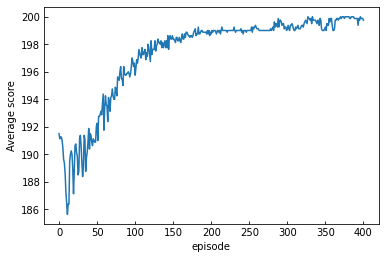

In [6]:
plt.plot(mean_rewards)
plt.ylabel('Average score')
plt.xlabel('episode')
plt.show()

---

# Evaluate

In [7]:
from ppo import PPOAgent
import torch
import gym

env= gym.make('CartPole-v0')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
agent = PPOAgent(state_size=env.observation_space.shape[0],
                 action_size=env.action_space.n, 
                 seed=0,
                 hidden_layers=[64,64],
                 lr_policy=1e-4, 
                 use_reset=True,
                 device=device)

In [8]:
gym.__version__

'0.21.0'

In [9]:
agent.policy.load_state_dict(torch.load('policy_cartpole.pth', map_location=lambda storage, loc: storage))

<All keys matched successfully>

In [10]:
from matplotlib import animation, rc
rc('animation', html='jshtml')

In [11]:
import matplotlib
matplotlib.__version__

'3.4.2'

In [12]:
import random as rand

# function to animate a list of frames
def animate_frames(frames):
    plt.axis('off')

    # color option for plotting
    # use Greys for greyscale
    cmap = None if len(frames[0].shape)==3 else 'Greys'
    patch = plt.imshow(frames[0], cmap=cmap)  

    fanim = animation.FuncAnimation(plt.gcf(), \
        lambda x: patch.set_data(frames[x]), frames = len(frames), interval=50)
    
    return fanim

In [13]:
import time
def play(env, policy, times, asy = 0, level = 1):
    frame1 = env.reset()
    reward = 0

    anim_frames = []

    for i in range(times):

        anim_frames.append(env.render(mode='rgb_array'))
        frame_input = torch.from_numpy(frame1).unsqueeze(0).float().to(device)
        t1 = time.time()
        action = policy.act(frame_input)['a'].cpu().numpy()
        t2 = time.time()
        frame1, _, is_done, _ = env.step(int(action))
        t3 = time.time()
        repeat = level * int((t2 - t1)/(t3 - t2))
        reward += 1
        if asy:
            for j in range(repeat):
                frame1, _, is_done, _ = env.step(int(action))
                reward += 1
                if is_done:
                    print("reward :", reward)
                    print(i)
                    print(repeat)
                    break
        if is_done:
            print("reward :", reward)
            break
    
    env.close()
    
    return animate_frames(anim_frames)

2022-01-23 23:11:42.752 Python[1053:11723] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/yt/3gz8yy8s1ks3w9hgqhvppyyc0000gn/T/org.python.python.savedState


reward : 10
0
9
reward : 10


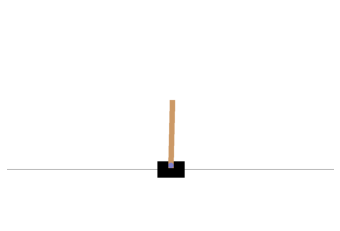

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/lwyjo/ppo/150wspd1/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/lwyjo/ppo/150wspd1/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/lwyjo/ppo/150wspd1/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/lwyjo/ppo/150wspd1/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/lwyjo/

In [14]:
play(env, agent.policy, 200, 1)